In [9]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms, utils
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from glob import glob
import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import time
import os
import copy
import pandas as pd
from PIL import Image
from skimage import io, transform
import random
from tqdm import tqdm
from sklearn.utils import shuffle
from random import randint

In [3]:
from dataloaders.PhotoDataset import PhotoDataset
from models.Vgg16FeatureModel import Vgg16FeatureModel
from models.PasticheModel import ResBlock, CondConvolution, Upsampling, PasticheModel
from train.Trainer import Trainer

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dataset_images = "../dataset/train2017/train2017/"
style_images_dir = glob(os.path.join("styles", '*.jpg'))
num_styles = len(style_images_dir)
image_size = 256
num_workers = 2
batch_size = 8

mean = [0.485, 0.456, 0.406]
std=[0.229, 0.224, 0.225]

layers = {
            '3':"relu1_2",
            '8':"relu2_2",
            '15':"relu3_3",
            '22':"relu4_3",
        }
content_layer = "relu3_3"
style_layers = {
    "relu1_2": 1.0,#0.4,
    "relu2_2": 1.0,#0.3,
    "relu3_3": 1.0,#0.2,
    "relu4_3": 1.0,#0.1
} 
model_dir="new_style/"
epoches = 1

In [5]:
data_transform = transforms.Compose([
        transforms.Resize(image_size),
        transforms.CenterCrop(image_size),
        transforms.ToTensor(),
        transforms.Normalize(mean=mean,
                             std=std)
    ])

photo_dataset = PhotoDataset(root_dir=dataset_images, transform = data_transform)

dataloader = DataLoader(photo_dataset, batch_size=batch_size,
                        shuffle=True, num_workers=num_workers)

vggfmodel = Vgg16FeatureModel(layers, device)

pastichemodel = PasticheModel(num_styles)
pastichemodel = pastichemodel.to(device)

optimizer = optim.Adam(pastichemodel.parameters(), lr=0.0001, betas=(0.9, 0.999))

style_targets = [vggfmodel.get_style_gram(data_transform(Image.open(style_image_dir).convert('RGB')).unsqueeze(0).to(device)) for style_image_dir in style_images_dir]

In [6]:
im = Image.open("../bird.jpg").convert('RGB')
transform = transforms.Compose([
        transforms.Resize(512),
        transforms.ToTensor(),
        transforms.Normalize(mean=mean,
                             std=std)
    ])

In [7]:
trainer = Trainer(vggfmodel,pastichemodel,style_targets,device, layers,content_layer,style_layers)

In [ ]:
content_loss, style_loss = trainer.train(dataloader, optimizer, epoches, save_dir=model_dir,eval_set=(im,transform, 'temp_eval'))


15.611381530761719, 378.8951416015625:   0%|          | 27/14786 [00:28<3:08:43,  1.30it/s]

In [8]:
# trainer.load_model_weights("style16/pastichemodel-FINAL.pth")

In [9]:
trainer.set_mode("eval")

Wall time: 279 ms


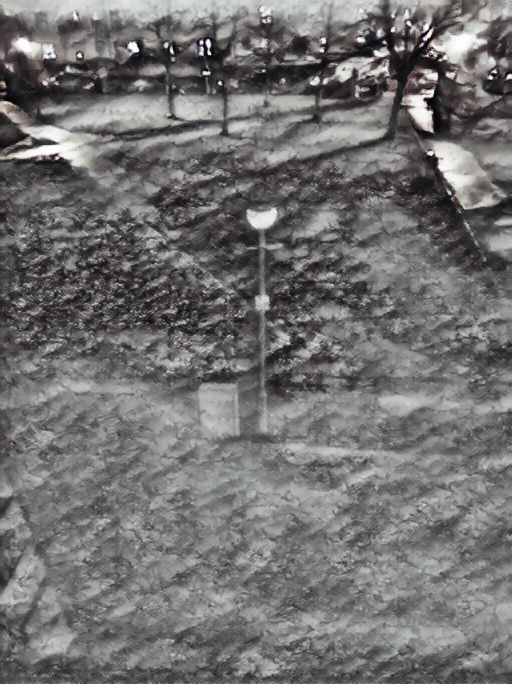

In [10]:
im = Image.open("../profile.jpg").convert('RGB')
transform = transforms.Compose([
        transforms.Resize(512),
        transforms.ToTensor(),
        transforms.Normalize(mean=mean,
                             std=std)
    ])
%time trainer.eval_image(im, transform, 2)

In [1]:
import torch
from torchvision import transforms
from inference.Inferencer import Inferencer
from models.PasticheModel import PasticheModel
from PIL import Image

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

num_styles = 16
image_size =512
model_save_dir = "style16/pastichemodel-FINAL.pth"

pastichemodel = PasticheModel(num_styles)

inference = Inferencer(pastichemodel,device,image_size)
inference.load_model_weights(model_save_dir)

In [5]:
example_image_path = "../bird.jpg"
im = Image.open(example_image_path).convert('RGB')

Wall time: 102 ms


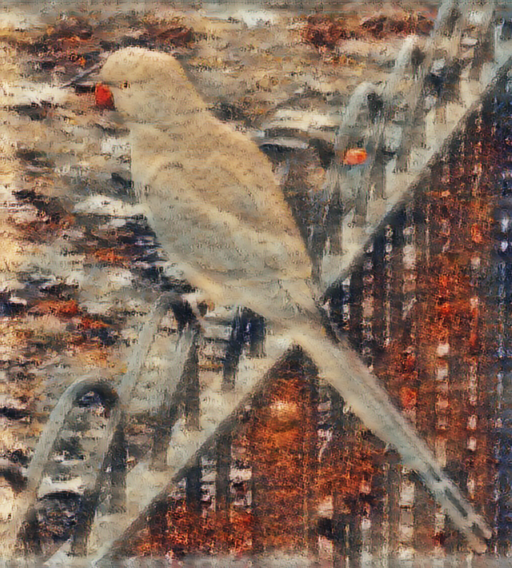

In [7]:
%time inference.eval_image(im, 1,2,1.0)